## Install required packages

In [1]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib pandas scikit-learn
!pip install albumentations
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 157.3 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 177.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 232.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 136.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 178.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into acc

## Downloading the Dataset

In [1]:
import os
import requests
import zipfile
from tqdm import tqdm

# Create data directory
os.makedirs('data', exist_ok=True)

# URL for the PlantVillage dataset on Mendeley
url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
output_path = "data/plant_village.zip"

# Download with progress bar
print("Downloading PlantVillage dataset...")
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024

with open(output_path, "wb") as f, tqdm(
    total=total_size, unit='B', unit_scale=True, desc=output_path
) as progress_bar:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        f.write(data)

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('data/PlantVillage')

print("Dataset downloaded and extracted successfully!")

data/plant_village.zip: 100%|██████████| 868M/868M [00:44<00:00, 19.6MB/s] 


Extracting dataset...
Dataset downloaded and extracted successfully!


## Dataset Class Implementation

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        # Get all image paths and labels
        self.data = []
        self.class_map = {}
        class_idx = 0
        
        for class_folder in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_path):
                self.class_map[class_idx] = class_folder
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.data.append({
                            'image_path': os.path.join(class_path, img_name),
                            'class_idx': class_idx
                        })
                class_idx += 1
        
        # Save class mapping
        self.num_classes = class_idx
        print(f"Loaded dataset with {len(self.data)} images across {self.num_classes} classes")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_data = self.data[idx]
        image_path = img_data['image_path']
        class_idx = img_data['class_idx']
        
        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, class_idx

## Model Architecture

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F

class DiseaseDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(DiseaseDetectionModel, self).__init__()
        # Use ResNet50 as backbone
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        # Disease classification head
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Severity estimation head (regression)
        self.severity_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Normalize severity between 0-1
        )
        
    def forward(self, x):
        features = self.backbone(x)
        disease_pred = self.classification_head(features)
        severity_pred = self.severity_head(features)
        return disease_pred, severity_pred

## Disease Segmentation Model

In [3]:
import segmentation_models_pytorch as smp

class DiseaseSegmentationModel(nn.Module):
    def __init__(self):
        super(DiseaseSegmentationModel, self).__init__()
        # Use DeepLabV3+ with ResNet50 backbone
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            classes=1,
            activation="sigmoid",
        )
        
    def forward(self, x):
        return self.model(x)

## Training Function

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time
import copy
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Initialize history dictionaries
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, severity = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

## Training the Model and generating results

Using device: cuda:0
Using 2 GPUs!
Loaded dataset with 2645 images across 39 classes


/home/panchani.d/.conda/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/panchani.d/.conda/envs/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
train Loss: 0.4352 Acc: 0.8875
val Loss: 1.4685 Acc: 0.9017

Epoch 2/25
----------
train Loss: 0.2696 Acc: 0.9244
val Loss: 0.1216 Acc: 0.9509

Epoch 3/25
----------
train Loss: 0.2021 Acc: 0.9367
val Loss: 0.1854 Acc: 0.9584

Epoch 4/25
----------
train Loss: 0.2016 Acc: 0.9419
val Loss: 0.1228 Acc: 0.9452

Epoch 5/25
----------
train Loss: 0.1992 Acc: 0.9357
val Loss: 0.1043 Acc: 0.9660

Epoch 6/25
----------
train Loss: 0.2048 Acc: 0.9329
val Loss: 0.1026 Acc: 0.9698

Epoch 7/25
----------
train Loss: 0.1473 Acc: 0.9428
val Loss: 0.0772 Acc: 0.9490

Epoch 8/25
----------
train Loss: 0.1048 Acc: 0.9537
val Loss: 0.0709 Acc: 0.9716

Epoch 9/25
----------
train Loss: 0.1156 Acc: 0.9556
val Loss: 0.0693 Acc: 0.9716

Epoch 10/25
----------
train Loss: 0.1033 Acc: 0.9603
val Loss: 0.0710 Acc: 0.9716

Epoch 11/25
----------
train Loss: 0.1171 Acc: 0.9584
val Loss: 0.0763 Acc: 0.9660

Epoch 12/25
----------
train Loss: 0.1209 Acc: 0.9504
val Loss: 0.0744 Acc: 0.9679

E

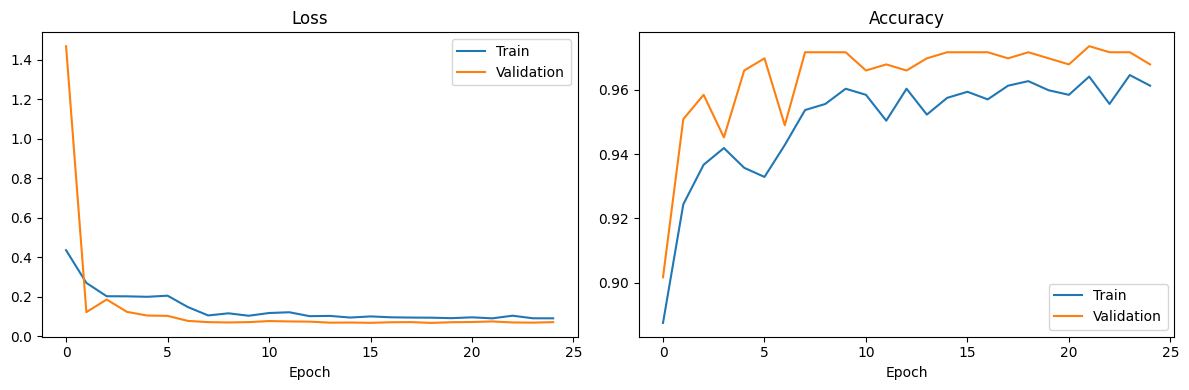

Training completed and model saved!


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

def main():
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Check if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
    
    # Define transformations
    train_transform = A.Compose([
        A.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(height=256, width=256),  # Corrected
        A.CenterCrop(height=224, width=224),  # Corrected
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Create dataset
    dataset_path = 'data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation'
    full_dataset = PlantDiseaseDataset(root_dir=dataset_path, transform=train_transform)
    
    # Save class mapping to file
    import json
    with open('class_mapping.json', 'w') as f:
        json.dump(full_dataset.class_map, f)
    
    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Create a copy of the validation dataset with val transforms
    val_dataset.dataset.transform = val_transform
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    # Initialize model
    num_classes = full_dataset.num_classes
    model = DiseaseDetectionModel(num_classes=num_classes)
    
    # Use multiple GPUs if available
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # Train model
    model, history = train_model(
        model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25
    )
    
    # Save model
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), 'models/plant_disease_model.pth')
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    print("Training completed and model saved!")

if __name__ == "__main__":
    main()

## Inference Script

In [13]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
import os
import torch.nn as nn
import torchvision.models as models

class DiseaseDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(DiseaseDetectionModel, self).__init__()
        # Use ResNet50 as backbone
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        # Disease classification head
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Severity estimation head (regression)
        self.severity_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Normalize severity between 0-1
        )
        
    def forward(self, x):
        features = self.backbone(x)
        disease_pred = self.classification_head(features)
        severity_pred = self.severity_head(features)
        return disease_pred, severity_pred

def predict_disease(model, image_path, class_map, device):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transformations
    transform = A.Compose([
        A.Resize(height=256, width=256),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs, severity = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        
    # Get class name and severity
    class_idx = preds.item()
    class_name = class_map[str(class_idx)]
    severity_value = severity.item() * 100  # Convert to percentage
    
    # Display results
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f'Disease: {class_name}\nSeverity: {severity_value:.2f}%', 
             horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return class_name, severity_value

def batch_predict(model, image_folder, class_map, device, output_folder='predictions'):
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all images in the folder
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    results = []
    
    for image_path in image_paths:
        class_name, severity = predict_disease(model, image_path, class_map, device)
        results.append({
            'image': os.path.basename(image_path),
            'disease': class_name,
            'severity': severity
        })
    
    # Save results to CSV
    import pandas as pd
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(output_folder, 'predictions.csv'), index=False)
    
    print(f"Predictions saved to {os.path.join(output_folder, 'predictions.csv')}")
    
    return results

## Calling the prediction function to predict the severity of diseases

Using device: cuda:0
Image exists at data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation/Peach___healthy/image (9).JPG


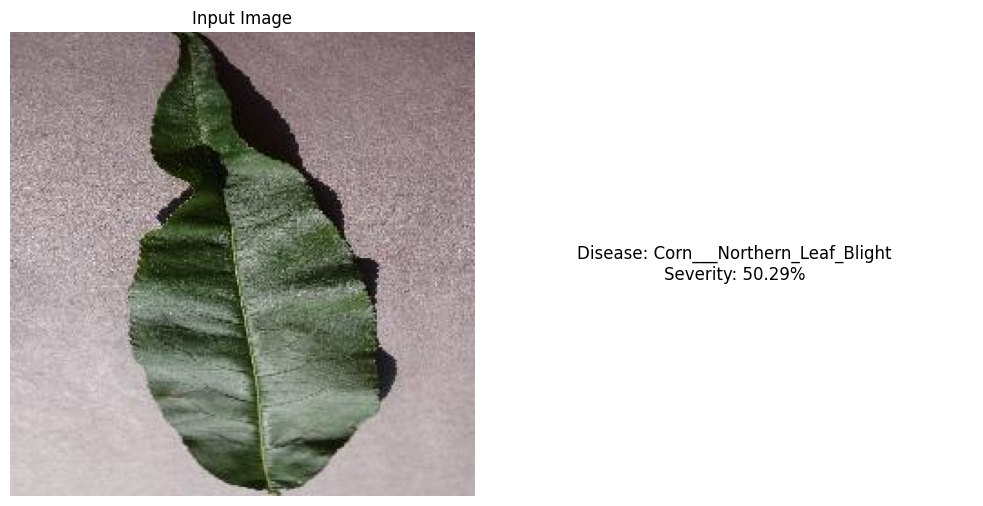

In [14]:
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load class mapping
    with open('class_mapping.json', 'r') as f:
        class_map = json.load(f)
    
    # Initialize model
    num_classes = len(class_map)
    model = DiseaseDetectionModel(num_classes=num_classes)
    
    # Load the state dict and remove the 'module.' prefix
    state_dict = torch.load('models/plant_disease_model.pth', map_location=device)
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    
    model = model.to(device)
    
    # Make prediction on a single image
    image_path = "data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation/Peach___healthy/image (9).JPG"  # Replace with actual path
    if os.path.exists(image_path):
        print(f"Image exists at {image_path}")
        predict_disease(model, image_path, class_map, device)
    else:
        print(f"Image not found at {image_path}")
        # Try to find an image in the dataset
        for root, dirs, files in os.walk("data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation"):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    sample_image = os.path.join(root, file)
                    print(f"Found sample image: {sample_image}")
                    predict_disease(model, sample_image, class_map, device)
                    break
            if 'sample_image' in locals():
                break

## Evaluating and Visualizing the Model

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

def evaluate_model(model, dataloader, device, class_map):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Find unique classes in the data
    unique_classes = sorted(set(all_labels).union(set(all_preds)))
    
    # Get class names for the classes that are actually present
    class_names = [class_map[str(i)] for i in unique_classes]
    
    # Calculate metrics with labels parameter
    report = classification_report(
        all_labels, 
        all_preds, 
        labels=unique_classes,
        target_names=class_names, 
        output_dict=True
    )
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    
    # Print classification report
    print("\nClassification Report:")
    for class_name in class_names:
        print(f"{class_name}:")
        print(f"  Precision: {report[class_name]['precision']:.4f}")
        print(f"  Recall: {report[class_name]['recall']:.4f}")
        print(f"  F1-Score: {report[class_name]['f1-score']:.4f}")
        print()
    
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    
    return report, cm

## Generating a confusion matrix 

Using device: cuda:0

Classification Report:
Background_without_leaves:
  Precision: 0.9974
  Recall: 0.9983
  F1-Score: 0.9978

Corn___Cercospora_leaf_spot Gray_leaf_spot:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Corn___Northern_Leaf_Blight:
  Precision: 0.6075
  Recall: 0.9826
  F1-Score: 0.7508

Corn___healthy:
  Precision: 0.9905
  Recall: 1.0000
  F1-Score: 0.9952

Pepper,_bell___healthy:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Squash___Powdery_mildew:
  Precision: 0.7500
  Recall: 0.4091
  F1-Score: 0.5294

Strawberry___Leaf_scorch:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Tomato___Late_blight:
  Precision: 0.9934
  Recall: 0.9804
  F1-Score: 0.9868

Tomato___healthy:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Overall Accuracy: 0.9656


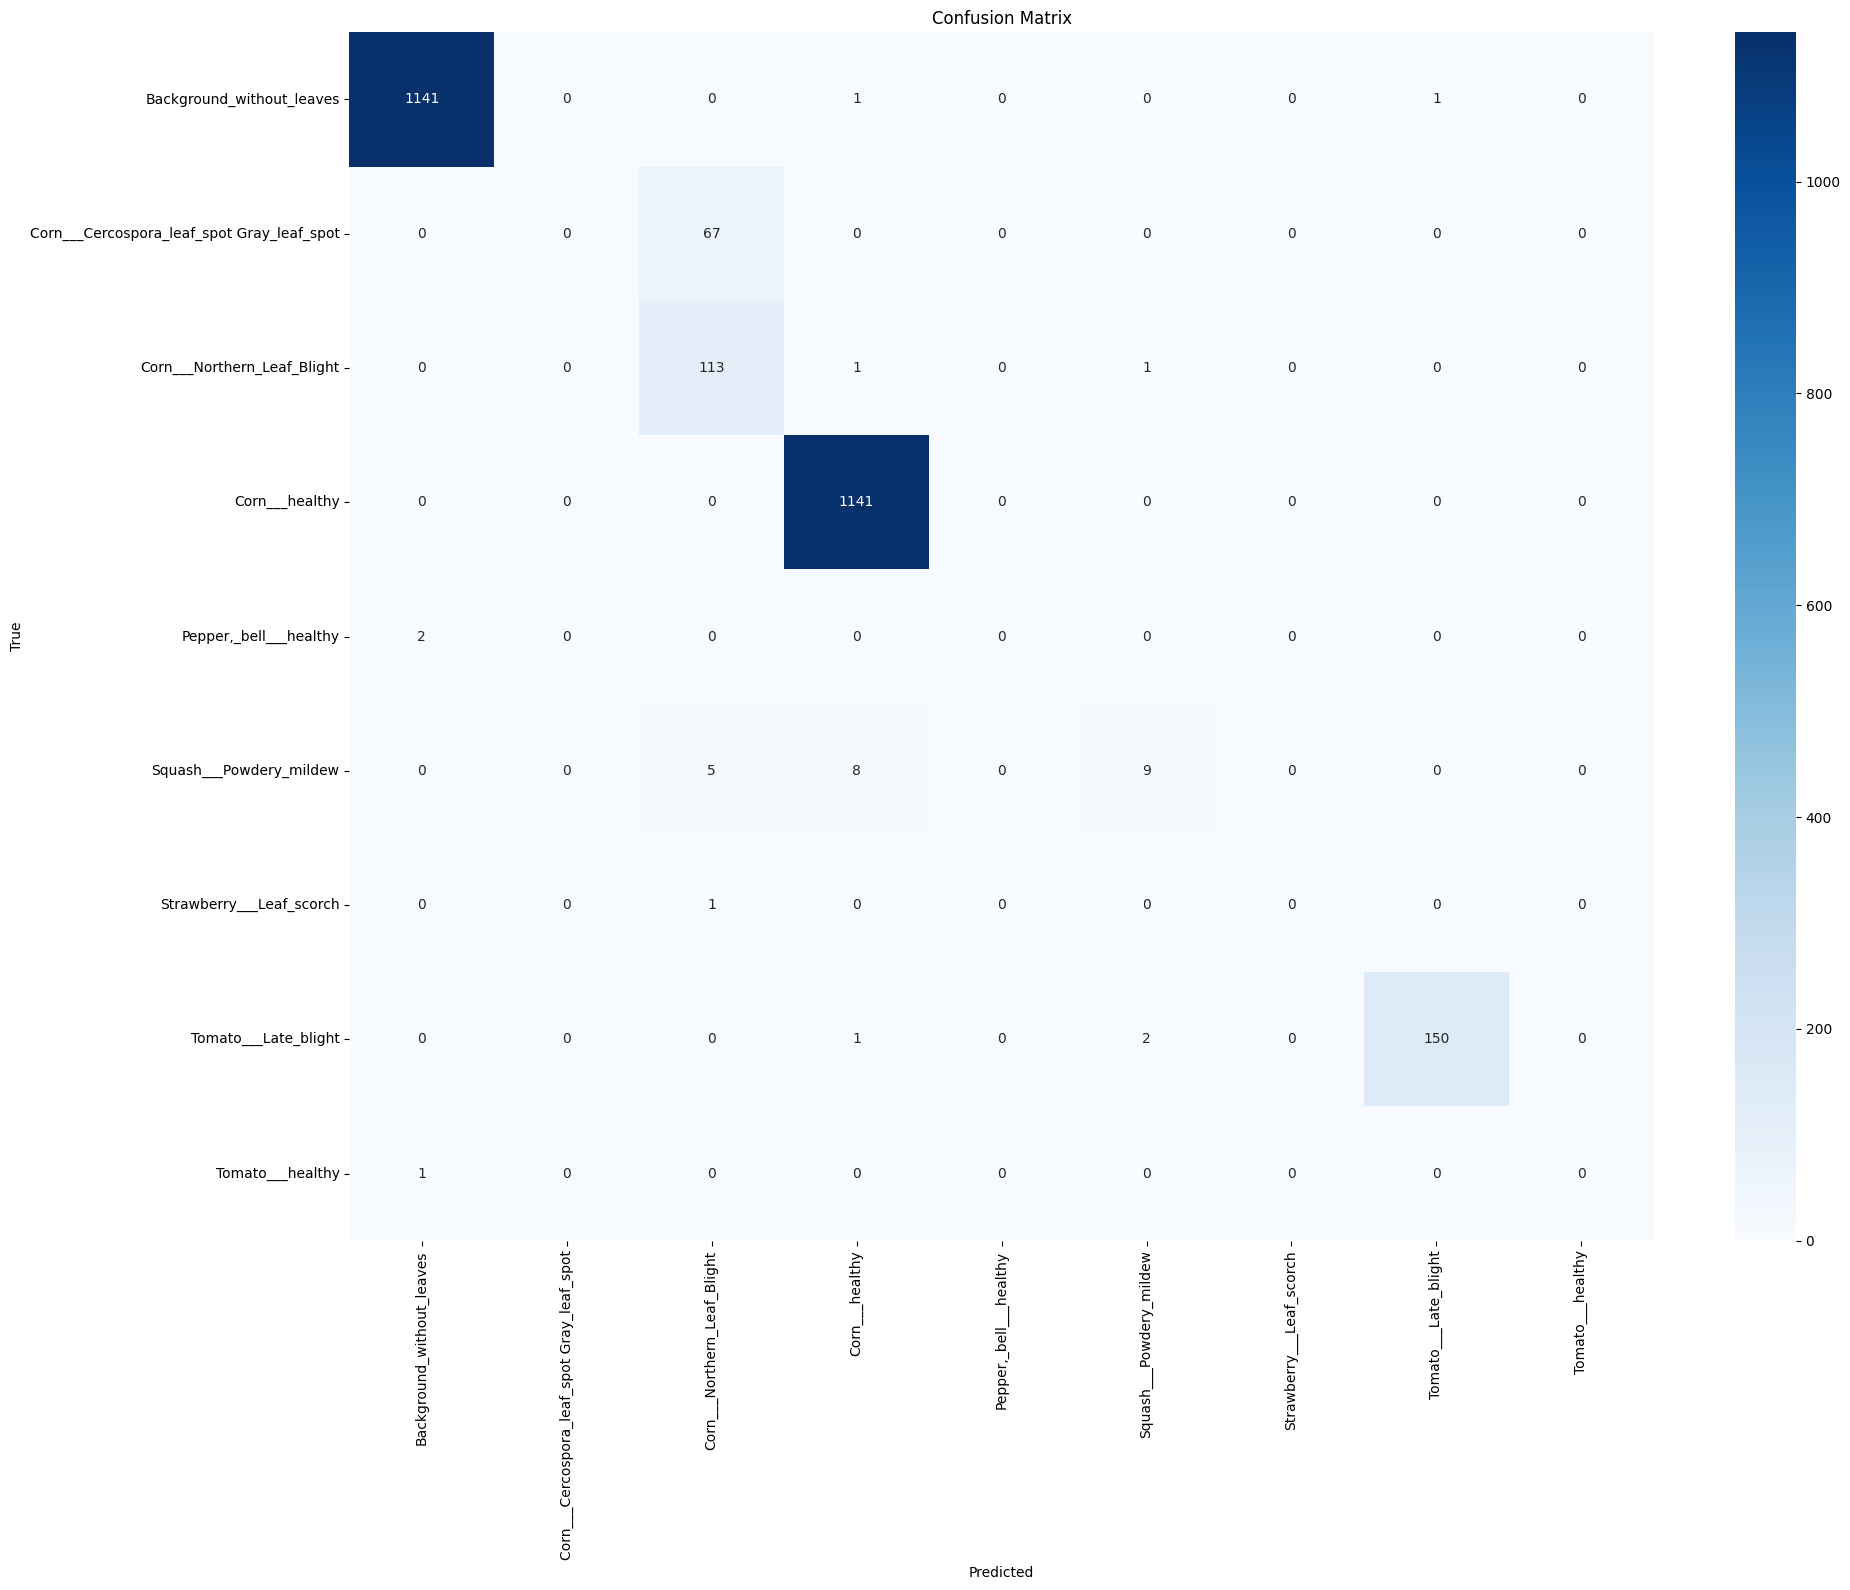

In [19]:
import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load class mapping
with open('class_mapping.json', 'r') as f:
    class_map = json.load(f)

# Initialize model
num_classes = len(class_map)
model = DiseaseDetectionModel(num_classes=num_classes)

# Load the state dict and remove the 'module.' prefix
state_dict = torch.load('models/plant_disease_model.pth', map_location=device)
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model = model.to(device)

# Create test dataset and dataloader
import cv2
test_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_dataset = PlantDiseaseDataset(
    root_dir='data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation',
    transform=test_transform,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Call the evaluate function
report, cm = evaluate_model(model, test_loader, device, class_map)

## Making an Activation Map depicting the region that a disease is likely to spread from

In [11]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

def visualize_activation_maps(model, image_path, class_map, device):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transformations
    transform = A.Compose([
        A.Resize(height=256, width=256),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Get the original image for overlay
    orig_image = cv2.resize(image, (224, 224))
    orig_image = orig_image / 255.0  # Normalize to 0-1
    
    # Forward pass with gradient
    model.eval()
    image_tensor.requires_grad_()
    
    # Get the output and target class
    outputs, _ = model(image_tensor)
    target_class = outputs.argmax(dim=1).item()
    
    # Get the gradient of the output with respect to the input
    model.zero_grad()
    outputs[0, target_class].backward()
    
    # Get the gradients
    gradients = image_tensor.grad.data.cpu().numpy()[0]
    
    # Pool the gradients across the channels
    pooled_gradients = np.mean(gradients, axis=(1, 2))
    
    # Get the activations from the last convolutional layer
    # This assumes the model has a backbone attribute with a forward hook
    # If your model structure is different, you'll need to adjust this
    if hasattr(model, 'module'):  # For DataParallel models
        activations = model.module.backbone(image_tensor).detach().cpu().numpy()[0]
    else:
        activations = model.backbone(image_tensor).detach().cpu().numpy()[0]
    
    # Weight the channels by the gradients
    for i in range(min(activations.shape[0], len(pooled_gradients))):
        activations[i] *= pooled_gradients[i]
    
    # Average the channels and create heatmap
    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    
    # Normalize the heatmap
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    # Resize heatmap to match the input image size
    heatmap = cv2.resize(heatmap, (224, 224))
    
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Overlay the heatmap on the original image
    superimposed_img = heatmap * 0.4 + orig_image
    superimposed_img = superimposed_img / np.max(superimposed_img)  # Normalize
    
    # Display the results
    class_name = class_map[str(target_class)]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Activation Map')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f'Prediction: {class_name}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('activation_map.png')
    plt.show()
    
    return class_name, heatmap, superimposed_img

Using device: cuda:0
Processing: data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation/Blueberry___healthy/image (1).JPG


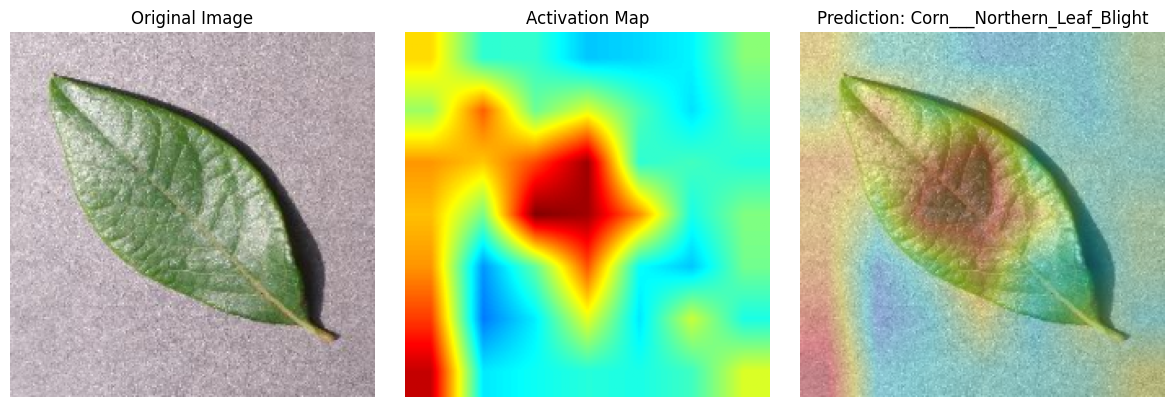

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import warnings
import os

# Suppress warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load class mapping
import json
with open('class_mapping.json', 'r') as f:
    class_map = json.load(f)

# Initialize model
num_classes = len(class_map)
model = DiseaseDetectionModel(num_classes=num_classes)

# Load the state dict and remove the 'module.' prefix
state_dict = torch.load('models/plant_disease_model.pth', map_location=device, weights_only=True)
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model = model.to(device)

folder_path = "data/PlantVillage/Plant_leave_diseases_dataset_without_augmentation/Blueberry___healthy"
for file in os.listdir(folder_path):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(folder_path, file)
        print(f"Processing: {image_path}")
        visualize_activation_maps(model, image_path, class_map, device)
        break  # Remove this if you want to process all images